Welcome!

In this notebook, you'll get a taste of training your own battlesnake agent using reinforcement learning.

First, we need to install some dependencies. You'll need to reboot the notebook once they're installed

Unfortunately for stable baselines to work properly, we need an old version < 2.0 of tensorflow installed

In [18]:
# !pip install tensorflow==1.15 -q
# !rm -rf pytorch-a2c-ppo-acktr-gail/
# !rm -rf gym-battlesnake/
# !git clone https://github.com/cbinners/pytorch-a2c-ppo-acktr-gail -q
# !git clone https://github.com/cbinners/gym-battlesnake -q
# !cd gym-battlesnake/ && pip install -e . -q
# !cd .
# !cd pytorch-a2c-ppo-acktr-gail/ && pip install -e . -q

#You'll have to restart this notebook once you've installed the above


In [19]:
# Load up our dependencies
import numpy as np
import math
import random
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from a2c_ppo_acktr.algo import PPO
from a2c_ppo_acktr.model import Policy, NNBase
from a2c_ppo_acktr.storage import RolloutStorage
from collections import deque
from gym_battlesnake.gymbattlesnake import BattlesnakeEnv, Rewards

device = torch.device('cuda')

In [20]:
# From https://github.com/fastai/fastai2/blob/master/fastai2/vision/models/xresnet.py
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

# See: https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/model.py
# for examples
        
class SnakePolicyBase(NNBase):
    ''' Neural Network Policy for our snake. This is the brain '''
    # hidden_size must equal the output size of the policy_head
    def __init__(self, num_inputs, recurrent=False, hidden_size=128): 
        super().__init__(recurrent, hidden_size, hidden_size)
        
        # We'll define a 3-stack CNN with leaky_relu activations and a batchnorm
        # here.
        self.base = nn.Sequential(
            nn.Conv2d(17, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
        )
        
        # Try yourself: Try different pooling methods
        # We add a pooling layer since it massively speeds up training
        # and reduces the number of parameters to learn.
        self.pooling = nn.AdaptiveMaxPool2d(2)
        
        # Try yourself: Change the number of features
        # 64 channels * 4x4 pooling outputs = 1024
        self.fc1 = nn.Linear(in_features=32*2*2, out_features=128)
        
        # Value head predicts how good the current board is
        self.value_head = nn.Linear(in_features=128, out_features=1)
        
        # Policy network gives action probabilities
        # The output of this is fed into a fully connected layer with 4 outputs
        # (1 for each possible direction)
        self.policy_head = nn.Linear(in_features=128, out_features=128)
        
        # Use kaiming initialization in our feature layers
        init_cnn(self)
        
    def forward(self, obs, rnn_hxs, masks):
        out = F.leaky_relu(self.base(obs))
        out = self.pooling(out).view(-1, 128)
        out = F.leaky_relu(self.fc1(out))
        
        value_out = self.value_head(out)
        policy_out = self.policy_head(out)
        
        return value_out, policy_out, rnn_hxs
    
class PredictionPolicy(Policy):
    """ Simple class that wraps the packaged policy with the prediction method needed by the gym """

    def predict(self, inputs, deterministic=False):
        # Since this called from our gym environment
        # (and passed as a numpy array), we need to convert it to a tensor
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        value, actor_features, rnn_hxs = self.base(inputs, None, None)
        dist = self.dist(actor_features)

        if deterministic:
            action = dist.mode()
        else:
            action = dist.sample()

        return action, value
        
def create_policy(obs_space, act_space, base):
    """ Returns a wrapped policy for use in the gym """
    return PredictionPolicy(obs_space, act_space, base=base)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
# Number of parallel environments to generate games in
n_envs = 208
# Number of steps per environment to simulate
n_steps = 600

# The total training set size per iteration is n_envs * n_steps

training_rewards = Rewards(win=3, loss=-5, kill=1, eat=0.25)

# The gym environment
env = BattlesnakeEnv(n_threads=1, n_envs=n_envs, rewards=training_rewards)

# Storage for rollouts (game turns played and the rewards)
rollouts = RolloutStorage(n_steps,
                          n_envs,
                          env.observation_space.shape,
                          env.action_space,
                          n_steps)
env.close()

# Create our policy as defined above
policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)
best_old_policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)

# Lets make the old policy the same as the current one
best_old_policy.load_state_dict(policy.state_dict())

# OR LOAD A SAVED MODEL
# ie: policy = torch.load('saved_models/my_model.pt')

agent = PPO(policy,
            value_loss_coef=0.5,
            entropy_coef=0.01,
            max_grad_norm=0.5,
            clip_param=0.2,
            ppo_epoch=4,
            num_mini_batch=32,
            eps=1e-5,
            lr=1e-3)

In [22]:
# Let's figure out how many trainable parameters our network has:
print(f"Trainable Parameters: {count_parameters(policy)}")

Trainable Parameters: 57093


In [23]:
# Let's define a method to check our performance against an older policy
# Determines an unbiased winrate check
def check_performance(current_policy, opponent, n_opponents=3, n_envs=1000, steps=1500, device=torch.device('cpu'), training_rewards=training_rewards):
    test_env = BattlesnakeEnv(n_threads=os.cpu_count(), n_envs=n_envs, opponents=[opponent for _ in range(n_opponents)], device=device, rewards=training_rewards)
    obs = test_env.reset()
    wins = 0
    losses = 0
    completed = np.zeros(n_envs)
    count = 0
    lengths = []
    win_rewards = []
    loss_rewards = []
    with torch.no_grad():
        # Simulate to a maximum steps across our environments, only recording the first result in each env.
        print("Running performance check")
        for step in tqdm(range(steps)):
            if count == n_envs:
                # Quick break
                print("Check Performance done @ step", step)
                break
            inp = torch.tensor(obs, dtype=torch.float32).to(device)
            action, _ = current_policy.predict(inp, deterministic=True)
            obs, reward, done, info = test_env.step(action.cpu().numpy().flatten())
            for i in range(test_env.n_envs):
                if completed[i] == 1:
                    continue # Only count each environment once
                if 'episode' in info[i]:
                    if info[i]['episode']['w']:
                        completed[i] = 1
                        count += 1
                        wins += 1
                        lengths.append(info[i]['episode']['l'])
                        win_rewards.append(info[i]['episode']['r'])
                    else:
                        completed[i] = 1
                        losses += 1
                        count += 1
                        lengths.append(info[i]['episode']['l'])
                        loss_rewards.append(info[i]['episode']['r'])

    winrate = wins / n_envs
    print("Wins", wins)
    print("Losses", losses)
    print("Average episode length:", np.mean(lengths))
    print("Average reward win:", np.mean(win_rewards))
    print("Average reward loss:", np.mean(loss_rewards))
    return winrate

In [ ]:
from tqdm.notebook import tqdm

# We'll play 4-way matches
env = BattlesnakeEnv(n_threads=2, n_envs=n_envs, opponents=[policy for _ in range(3)], device=device, rewards=training_rewards)
obs = env.reset()
rollouts.obs[0].copy_(torch.tensor(obs))

# How many iterations do we want to run
num_updates = 200

# Send our network and storage to the gpu
policy.to(device)
best_old_policy.to(device)
rollouts.to(device)

# Record mean values to plot at the end
rewards = []
value_losses = []
lengths = []


start = time.time()
new_policy_best = False
for j in range(num_updates):
    episode_rewards = []
    episode_lengths = []
    # Set
    policy.eval()
    print(f"Iteration {j+1}: Generating rollouts")
    for step in tqdm(range(n_steps)):
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = policy.act(rollouts.obs[step],
                                                            rollouts.recurrent_hidden_states[step],
                                                            rollouts.masks[step])
        obs, reward, done, infos = env.step(action.cpu().squeeze())
        obs = torch.tensor(obs)
        reward = torch.tensor(reward).unsqueeze(1)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])
                episode_lengths.append(info['episode']['l'])

        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

    with torch.no_grad():
        next_value = policy.get_value(
            rollouts.obs[-1],
            rollouts.recurrent_hidden_states[-1],
            rollouts.masks[-1]
        ).detach()
        
    # Set the policy to be in training mode (switches modules to training mode for things like batchnorm layers)
    policy.train()

    print("Training policy on rollouts...")
    # We're using a gamma = 0.99 and lambda = 0.95
    rollouts.compute_returns(next_value, True, 0.99, 0.95, False)
    value_loss, action_loss, dist_entropy = agent.update(rollouts)
    rollouts.after_update()

    # Set the policy into eval mode (for batchnorms, etc)
    policy.eval()
    
    total_num_steps = (j + 1) * n_envs * n_steps
    end = time.time()
    
    lengths.append(np.mean(episode_lengths))
    rewards.append(np.mean(episode_rewards))
    value_losses.append(value_loss)
    
    # Every 5 iterations, we'll print out the episode metrics
    if (j+1) % 5 == 0:
        print("\n")
        print("=" * 80)
        print("Iteration", j+1, "Results")
        # Check the performance of the current policy against the prior best
        winrate = check_performance(policy, best_old_policy, device=torch.device(device), training_rewards=training_rewards)
        print(f"Winrate vs prior best: {winrate*100:.2f}%")
        print(f"Median Length: {np.median(episode_lengths)}")
        print(f"Max Length: {np.max(episode_lengths)}")
        print(f"Min Length: {np.min(episode_lengths)}")

        # If our policy wins more than 30% of the games against the prior
        # best opponent, update the prior best.
        # Expected outcome for equal strength players is 25% winrate in a 4 player
        # match.
        if winrate > 0.3:
            print("Policy winrate is > 30%. Updating prior best model")
            best_old_policy.load_state_dict(policy.state_dict())
            new_policy_best = True
        else:
            print("Policy has not learned enough yet... keep training!")
        print("-" * 80)

Iteration 1: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training policy on rollouts...
Iteration 2: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 3: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 4: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 5: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 5 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 7
Wins 960
Losses 40
Average episode length: 3.064
Average reward win: 3.0
Average reward loss: -5.0
Winrate vs prior best: 96.00%
Median Length: 4.0
Max Length: 21
Min Length: 2
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 6: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 7: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 8: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 9: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 10: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 10 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 46
Wins 672
Losses 328
Average episode length: 9.389
Average reward win: 3.130952380952381
Average reward loss: -5.0
Winrate vs prior best: 67.20%
Median Length: 8.0
Max Length: 60
Min Length: 2
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 11: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 12: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 13: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 14: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 15: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 15 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 86
Wins 634
Losses 366
Average episode length: 27.376
Average reward win: 3.4274447949526814
Average reward loss: -5.0
Winrate vs prior best: 63.40%
Median Length: 15.0
Max Length: 96
Min Length: 2
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 16: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 17: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 18: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Check Performance done @ step 213
Wins 475
Losses 525
Average episode length: 75.537
Average reward win: 3.536842105263158
Average reward loss: -5.0
Winrate vs prior best: 47.50%
Median Length: 58.0
Max Length: 228
Min Length: 2
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 26: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 27: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 28: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 29: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 30: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 30 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 222
Wins 396
Losses 604
Average episode length: 97.155
Average reward win: 3.4646464646464645
Average reward loss: -5.0
Winrate vs prior best: 39.60%
Median Length: 71.0
Max Length: 251
Min Length: 2
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 31: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 32: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training policy on rollouts...
Iteration 39: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 40: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 40 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 319
Wins 364
Losses 636
Average episode length: 143.408
Average reward win: 3.2554945054945055
Average reward loss: -5.0
Winrate vs prior best: 36.40%
Median Length: 109.0
Max Length: 338
Min Length: 4
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 41: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 42: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 43: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 44: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 45: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training policy on rollouts...


Iteration 50 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

Check Performance done @ step 421
Wins 380
Losses 620
Average episode length: 171.902
Average reward win: 3.1578947368421053
Average reward loss: -5.0
Winrate vs prior best: 38.00%
Median Length: 129.0
Max Length: 416
Min Length: 4
Policy winrate is > 30%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 51: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 52: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 53: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 54: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...
Iteration 55: Generating rollouts


  0%|          | 0/600 [00:00<?, ?it/s]

Training policy on rollouts...


Iteration 55 Results
Running performance check


  0%|          | 0/1500 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



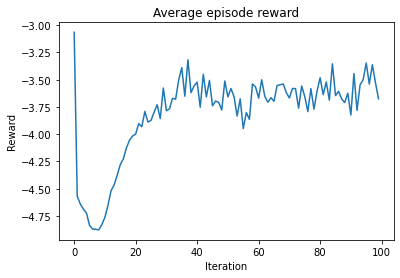

In [16]:
plt.clf()
plt.title("Average episode length")
plt.ylabel("Length")
plt.xlabel("Iteration")
plt.plot(lengths)
plt.show()

plt.title("Average episode reward")
plt.ylabel("Reward")
plt.xlabel("Iteration")
plt.plot(rewards)
plt.show()

In [17]:
torch.save(policy.state_dict(), 'models/bsg_weights_agg_2.pt')
#torch.save(best_old_policy.state_dict(), 'modals/bsg_weights_best_agg_1.pt')

## Our average episode length is increasing! This means our snakes are learning to live longer.

This is great... clearly our agent is improving! Let's take it a step further and visualize some games.

In [9]:
# To watch a replay, we need an environment
# Important: Make sure to use fixed orientation during visualization
playground = BattlesnakeEnv(n_threads=1, n_envs=1, opponents=[policy for _ in range(3)], fixed_orientation=True)

# Visualizing Some Games

Below, we'll create a simple rendering snippet that grabs some of the layer data and converts it into a game board.

We'll then render a few steps of some games to get a sense of how our player is doing.

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def obs_to_frame(obs):
    ''' Converts an environment observation into a renderable RGB image '''
    # First, let's find the game board dimensions from layer 5
    x_offset, y_offset = 0, 0
    done = False
    for x in range(23):
        if done:
            break
        for y in range(23):
            if obs[0][5][x][y] == 1:
                x_offset = x
                y_offset = y
                done = True
                break
    output = np.zeros((11, 11, 3), dtype=np.uint8)

    # See https://github.com/cbinners/gym-battlesnake/blob/master/gym_battlesnake/src/gamewrapper.cpp#L55 for
    # layer reference
    for x in range(23):
        for y in range(23):
            # Render snake bodies
            if obs[0][1][x][y] == 1:
                output[x-x_offset][y-y_offset] = 255 - 10*(255 - obs[0][2][x][y])
            # Render food
            if obs[0][4][x][y] == 1:
                output[x-x_offset][y-y_offset][0] = 255
                output[x-x_offset][y-y_offset][1] = 255
                output[x-x_offset][y-y_offset][2] = 0
            # Render snake heads as a red pixel
            if obs[0][0][x][y] > 0:
                output[x-x_offset][y-y_offset][0] = 255
                output[x-x_offset][y-y_offset][1] = 0
                output[x-x_offset][y-y_offset][2] = 0
            # Render snake heads
            if obs[0][6][x][y] == 1:
                output[x-x_offset][y-y_offset][0] = 0
                output[x-x_offset][y-y_offset][1] = 255
                output[x-x_offset][y-y_offset][2] = 0

    return output

# Reset the environment 
obs = playground.reset()

# Keep track of game frames to render
video = []

# Grab a set of frames to render
with torch.no_grad():
    for i in tqdm(range(300)):
        # Add the rendered observation to our frame stack
        video.append(obs_to_frame(obs))

        # Get the action our policy should take
        _, action, _, _ = policy.act(torch.tensor(obs, dtype=torch.float32).to('cuda'), None, None)

        # Perform our action and update our observation
        obs,_,_,_ = playground.step(action.cpu().squeeze())

# Render, adapted from here: https://stackoverflow.com/questions/57060422/fast-way-to-display-video-from-arrays-in-jupyter-lab

video = np.array(video, dtype=np.uint8)
fig = plt.figure()
im = plt.imshow(video[0,:,:,:])
plt.close()
def init():
    im.set_data(video[0,:,:,:])
def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0], interval=200)
HTML(anim.to_html5_video())

  0%|          | 0/300 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
torch.save(policy.state_dict(), 'example_weights.pt')

# Congratulations, you've now trained your own battlesnake agent!

Thanks for checking out our notebook!



In [8]:
from google.cloud import storage
import re
model_dir = 'gs://snakes-nat-2021-training/custom_job_20210610190815'
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

model_file = "bsg_weights"
m = re.search(r'gs:\/\/(.*)\/(.*)', model_dir)
bucket_name = m.group(1)
m_dir = m.group(2)
print(bucket_name)
print(m_dir)
upload_blob(bucket_name, f"{model_file}.pt", f"{m_dir}/{model_file}.pt")

snakes-nat-2021-training
custom_job_20210610190815
File bsg_weights.pt uploaded to custom_job_20210610190815/bsg_weights.pt.
